c4.8xlarge is too small (has around 2 responses/rec when pressured with 5 response/sec)

m4.16xlarge is also not great (has around 2 responses/sec when pressured with 5 resposnes/sec).

In [1]:
import msgpack
from copy import deepcopy
import pandas as pd
import numpy as np

today = "2021-05-24"
# today = "2021-05-25"
            
from responses import _cook_next
def _get_df(rate):
    with open(f"next/io/{today}/rate={rate}_responses.msgpack", "rb") as f:
        raw = msgpack.load(f)
    df = _cook_next(raw)
    print(rate, len(df))
    if not len(df):
        raise ValueError("No responses collected")
    key = "timestamp_query_generated"
    df[key] = pd.to_datetime(df[key])
    df = df.sort_values(by=key)
    df["time_from_start"] = (df[key] - df[key].min())
    df["yes"] = 1
    df = df.set_index("time_from_start")

    for key in ["head", "left", "right"]:
        df[f"{key}_smooth"] = df[f"{key}_obj"].apply(lambda x: int(x.strip("i.png")))
    df["dist_l"] = np.abs(df["head_smooth"] - df["left_smooth"])
    df["dist_r"] = np.abs(df["head_smooth"] - df["right_smooth"])
    left_wins = df["dist_l"] < df["dist_r"]
    df["winning_side"] = "right"
    df.loc[left_wins, "winning_side"] = "left"
    return df


rates = [0.5, 1, 2, 5]
rates = [5]
dfs = {rate: _get_df(rate) for rate in rates}
for rate, _df in dfs.items():
    _df["rate"] = rate
df = pd.concat(list(dfs.values()))

5 21961


In [257]:
df.head()

,alg_id,network_delay,response_time,timestamp_query_generated,puid,head,head_obj,left,left_obj,right,...,winner,winner_obj,yes,head_smooth,left_smooth,right_smooth,dist_l,dist_r,winning_side,rate
time_from_start,,,,,,,,,,,,,,,,,,,,,
0 days 00:00:00,STE,-0.404336,1.208688,2021-05-24 16:58:49.420900,386844fde3392cc686da26cac8930d_8,59,i0387.png,33,i0208.png,84,...,33,i0208.png,1,387,208,557,179,170,right,5
0 days 00:00:00.529081,STE,-0.394903,1.935879,2021-05-24 16:58:49.949981,386844fde3392cc686da26cac8930d_6,59,i0387.png,41,i0251.png,24,...,41,i0251.png,1,387,251,142,136,245,left,5
0 days 00:00:01.390088,STE,-0.100141,2.350956,2021-05-24 16:58:50.810988,386844fde3392cc686da26cac8930d_8,47,i0322.png,21,i0132.png,79,...,21,i0132.png,1,322,132,525,190,203,left,5
0 days 00:00:01.406686,STE,-0.115424,1.941208,2021-05-24 16:58:50.827586,386844fde3392cc686da26cac8930d_4,47,i0322.png,74,i0500.png,83,...,74,i0500.png,1,322,500,552,178,230,left,5
0 days 00:00:02.452182,STE,-0.106641,2.291417,2021-05-24 16:58:51.873082,386844fde3392cc686da26cac8930d_6,36,i0230.png,81,i0545.png,82,...,82,i0551.png,1,230,545,551,315,321,left,5


In [258]:
winning_side = df["winning_side"] == "right"

df["human_answer"] = "left"
right_wins = df["right_obj"] == df["winner_obj"]
left_wins = df["left_obj"] == df["winner_obj"]
head_wins = df["head_obj"] == df["winner_obj"]
right_wins.sum(), left_wins.sum(), head_wins.sum()
df.loc[right_wins, "human_answer"] = "right"

print(right_wins.mean(), winning_side.mean())  # good; randomized

(df["human_answer"] == df["winning_side"]).mean()

0.5010245435089477 0.5000227676335322


0.8330677109421247

In [259]:
df[["human_answer", "winning_side"]].iloc[:10]

,human_answer,winning_side
time_from_start,,
0 days 00:00:00,left,right
0 days 00:00:00.529081,left,left
0 days 00:00:01.390088,left,left
0 days 00:00:01.406686,left,left
0 days 00:00:02.452182,right,left
0 days 00:00:02.958921,right,right
0 days 00:00:03.105983,left,right
0 days 00:00:03.570152,right,right
0 days 00:00:04.010182,right,right


rate
5    AxesSubplot(0.125,0.125;0.775x0.755)
Name: network_delay, dtype: object

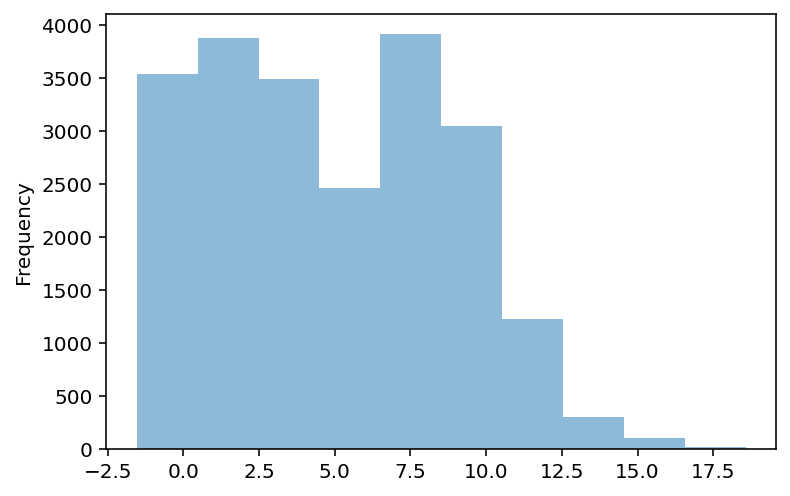

In [260]:
df.groupby("rate")["network_delay"].plot.hist(alpha=0.5)

In [261]:
# _responses_per_sec = df.index.total_seconds().astype(int).value_counts().to_numpy()
# responses_per_sec = pd.Series(_responses_per_sec)
# responses_per_sec.plot.hist()

29844.430208


(0.0, 800.0)

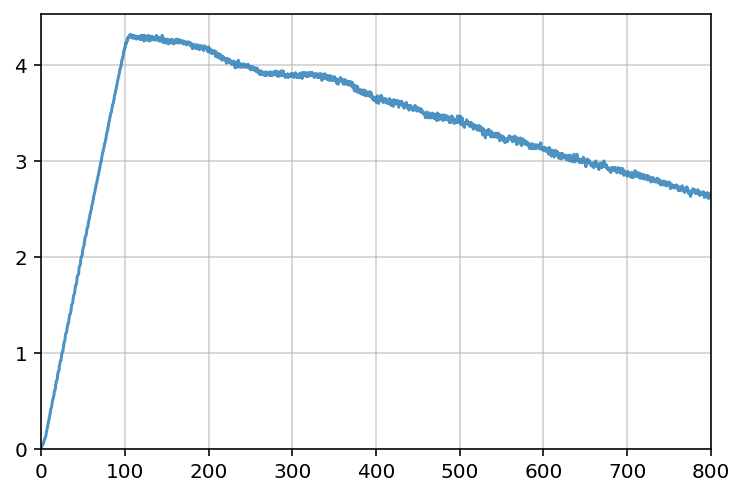

In [262]:
from datetime import timedelta
import matplotlib.pyplot as plt
n_sec = 100
def _get_rps(df):
    responses_p_sec = df.rolling(f"{n_sec}s")["yes"].sum() / n_sec
    rps = responses_p_sec.reset_index()
    rps["secs_from_start"] = rps["time_from_start"].dt.total_seconds()
    return rps

RPS = {rate: _get_rps(df[df.rate == rate]) for rate in df.rate.unique()}

fig, ax = plt.subplots()
# X = [0, 25e3]
X = None
total_time = 0
for k, rate in enumerate(reversed(rates)):
    rps = RPS[rate]
    total_time += rps["secs_from_start"].max()
    ax.plot(rps.secs_from_start, rps.yes, f"C{k}", alpha=0.8, label=rate)
    if X:
        ax.plot(X, [rate, rate])
    else:
        ax.set_xlim(0, 800)

print(total_time)
ax.grid(alpha=0.6)
ax.set_ylim(0, None)
ax.set_xlim(0, None)